In [1]:
import scanpy as sc
import scIB
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
exec(open("../../scIB/tests/utils.py").read())

In [3]:
adata = create_adata_dummy(pca=True, n_top_genes=2000, neighbors=True)
sc.tl.umap(adata)

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


HVG
Computed 2000 highly variable genes
PCA
Nearest Neigbours


In [4]:
# remove batches from cell type
repl = (2, 4)
adata.obs['batch'] = [repl[1] 
                      if row['celltype'] == '4Ery' and row['batch'] == repl[0]
                      else row['batch']
                      for _, row in adata.obs.iterrows()]

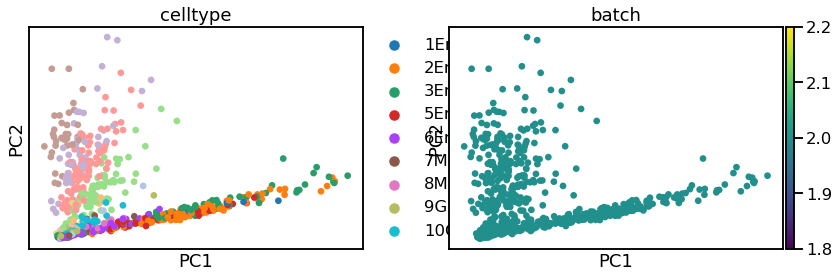

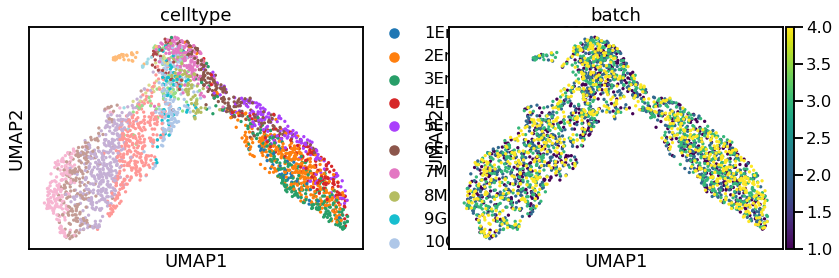

In [5]:
sc.pl.pca(adata[adata.obs['batch'] == 2], color=['celltype', 'batch'], palette=sc.pl.palettes.vega_20_scanpy)
sc.pl.umap(adata, color=['celltype', 'batch'], palette=sc.pl.palettes.vega_20_scanpy)

Get cell type labels that are in only a single batch

In [6]:
n_batch = adata.obs['batch'].nunique()
n_batch

4

In [7]:
obs_subset = adata.obs[['celltype', 'batch']].drop_duplicates()
batch_per_celltype = obs_subset.groupby('celltype').agg({'batch': "count"})
batch_per_celltype.head()

,batch
celltype,
1Ery,4
2Ery,4
3Ery,4
4Ery,3
5Ery,4


In [8]:
isolated_ct = batch_per_celltype.query('batch < @n_batch').index.tolist()

In [9]:
isolated_ct

['4Ery']

For each label compute:

+ clustering opt s.t. number of label in largest cluster is maximal
+ F1 score

In [10]:
def max_label_per_batch(adata, label_key, group_key, label):
    sub = adata.obs[adata.obs[label_key] == label].copy()
    return sub[group_key].value_counts().max()

In [11]:
sc.tl.louvain(adata, resolution=0.2, key_added='cluster')

In [12]:
max_label_per_batch(adata, 'celltype', 'cluster', '4Ery')

119

In [13]:
scIB.cl.opt_louvain(adata, 'celltype', 'cluster', function=max_label_per_batch, label='4Ery', force=True)

optimised clustering against celltype
optimal cluster resolution: 2.0
optimal score: 0


(2.0, 0,     resolution  score
 0          0.1    119
 1          0.2    119
 2          0.3    119
 3          0.4     65
 4          0.5     65
 5          0.6     65
 6          0.7     65
 7          0.8     76
 8          0.9     65
 9          1.0     76
 10         1.1     76
 11         1.2     76
 12         1.3     47
 13         1.4     47
 14         1.5     47
 15         1.6     47
 16         1.7     48
 17         1.8     48
 18         1.9     47
 19         2.0     47)

Compute F1-score

In [14]:
adata.obs[adata.obs["celltype"] == "4Ery"]["cluster"].value_counts().argmax()

'0'

In [15]:
scIB.me.score_isolated_label(adata, label_key='celltype', batch_key='batch', 
                     cluster_key="cluster", label="4Ery")

0.23152709359605914

In [16]:
scIB.me.isolated_labels(adata, label_key='celltype', batch_key='batch', cluster_key="cluster")

0.23152709359605914

In [17]:
scIB.me.isolated_labels(adata, label_key='celltype', batch_key='batch', 
                     cluster_key="cluster", all_=True)

{'4Ery': 0.23152709359605914}

In [18]:
scIB.me.isolated_labels(adata, label_key='celltype', batch_key='batch', 
                     cluster_key="cluster", cluster=False)

0.557001743465662